In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

from keras import backend as K
from keras.utils import plot_model
K.set_image_dim_ordering('th')
import os
import matplotlib.pyplot as plt
os.chdir("/home/ubuntu/data/")

from IPython.display import Image, display, clear_output
import datetime

Using TensorFlow backend.


In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'train'
validation_data_dir = 'validation'
test_dir = 'test'
nb_train_samples = 800
nb_validation_samples = 370
batch_size = 10


#reshape images
datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def save_bottlebeck_features():
    #datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train',
        bottleneck_features_train)

    print("done train")
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation',
            bottleneck_features_validation)
    print("done valid")
    return

def plot_nicely(history, filename_prefix=""):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    time_now = datetime.datetime.now()
    time_string = str(time_now.hour) + str(time_now.minute)
    fileName1 = filename_prefix + "_" + time_string + "_1.png"
    fileName2 = filename_prefix + "_" + time_string + "_2.png"
    
    plt.savefig(fileName1)
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(fileName2)
    plt.show()
    
    clear_output(True)
    display(Image(filename=fileName1))
    display(Image(filename=fileName2))
    return

def train_top_model(loss, optimizer):
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = None
    epoch_plot_step = 5
    for a in range(epochs // epoch_plot_step):
        if a == 0:
            history = model.fit(train_data, train_labels,
                      epochs=epoch_plot_step,
                      batch_size=batch_size,
                      validation_data=(validation_data, validation_labels))
        else:
            newHistory = model.fit(train_data, train_labels,
                      epochs=epoch_plot_step,
                      batch_size=batch_size,
                      validation_data=(validation_data, validation_labels))
            for b in history.history:
                history.history[b] += newHistory.history[b]
        
    file_prefix = "../download/5_"+str(loss)+"_"+str(optimizer)
    weights_file_title = file_prefix + ".h5"
    model.save_weights( weights_file_title )
    plot_nicely(history, file_prefix)
    title = "5_" + str(loss) + "_" + str(optimizer)
    
    print("ended fitting and saving")
    return history, title

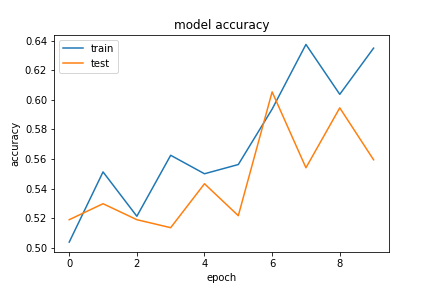

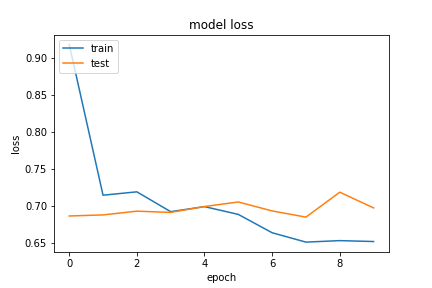

ended fitting and saving
Found 841 images belonging to 2 classes.


In [ ]:
def tune_loss_optimizer(loss, optimizer, epochs):
    save_bottlebeck_features()
    history, title = train_top_model(loss, optimizer)
    return history, title
    

loss_array = ["binary_crossentropy", "mean_squared_error"]
optimizer_array = ["rmsprop", "sgd"]
epochs = 10


title_array = []
history_array = []
for loss in loss_array:
    for optimizer in optimizer_array:
        history, title = tune_loss_optimizer(loss, optimizer, epochs)
        history_array += [history]
        title_array += [title]

In [ ]:
def plot_shared_xy(history_array, title_array, filename_prefix=""):
    time_now = datetime.datetime.now()
    time_string = str(time_now.hour) + str(time_now.minute)
    fileName1 = filename_prefix + "_" + time_string + "_1.png"
    fileName2 = filename_prefix + "_" + time_string + "_2.png"
    
    # plot acc
    f, axarr = plt.subplots(len(history_array), sharex=True, sharey=True, figsize=(10,8))

    for a,history in enumerate(history_array):
        axarr[a].plot(history.history['acc'])
        axarr[a].plot(history.history['val_acc'])
        axarr[a].set_title(title_array[a])
        axarr[a].set_ylabel('accuracy')
        axarr[a].legend(['train', 'test'], loc='upper left')
    
    plt.suptitle('model accuracy')
    axarr[-1].set_xlabel('epoch')
    
    f.subplots_adjust(hspace=0.3)
    plt.savefig(fileName1)
    plt.show()

    # plot loss
    
    clear_output(True)
    display(Image(filename=fileName1))
    #display(Image(filename=fileName2))
    return

plot_shared_xy(history_array,"../download/5_shared", title_array)